In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/goldstock.csv')
df.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1


In [2]:
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Display the summary of the dataset
print(df.info())

scaler = MinMaxScaler()

columns_to_scale = ['Close', 'Volume', 'Open', 'High', 'Low']

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2024-01-19 to 2014-01-22
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Close       2511 non-null   float64
 2   Volume      2511 non-null   float64
 3   Open        2511 non-null   float64
 4   High        2511 non-null   float64
 5   Low         2511 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 137.3 KB
None
            Unnamed: 0     Close    Volume      Open      High       Low
Date                                                                    
2024-01-19           0  0.938860  0.210968  0.935756  0.945630  0.949087
2024-01-18           1  0.931481  0.212155  0.918209  0.929889  0.934998
2024-01-17           2  0.917010  0.311469  0.939879  0.940029  0.931986
2024-01-16           3  0.939722  0.353136  0.960687  0.965814  0.954333
2024-01-12           4  0.960230  0.318775  0.941317 

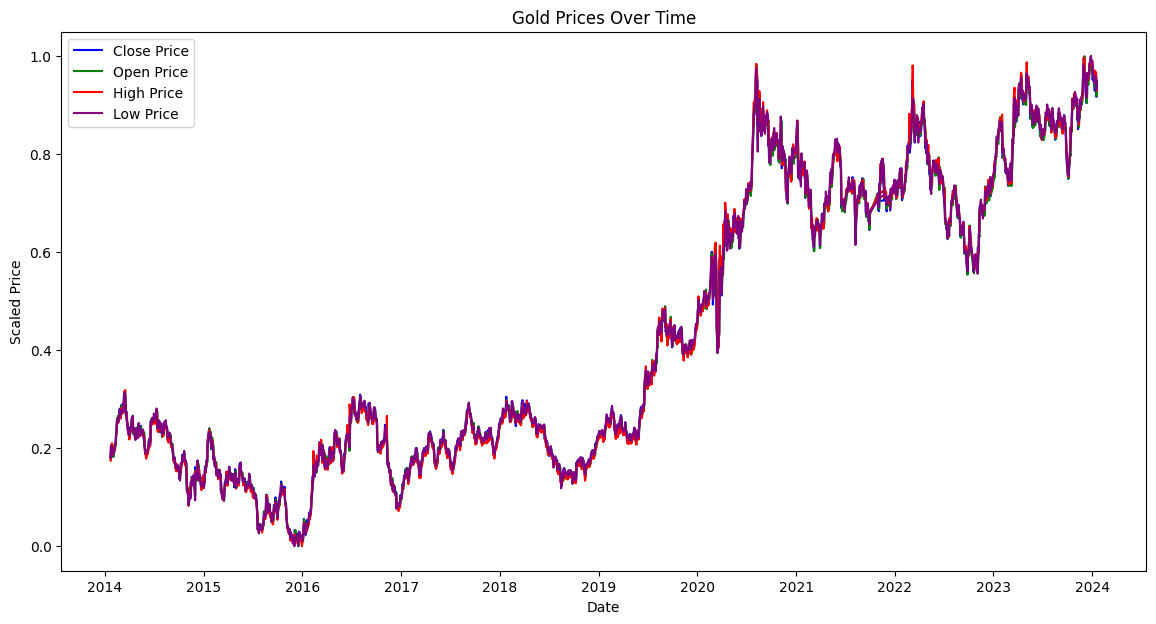

In [3]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['Open'], label='Open Price', color='green')
plt.plot(df['High'], label='High Price', color='red')
plt.plot(df['Low'], label='Low Price', color='purple')
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()



Summary Statistics:
        Unnamed: 0        Close       Volume         Open         High  \
count  2511.000000  2511.000000  2511.000000  2511.000000  2511.000000   
mean   1260.792911     0.430404     0.236237     0.428829     0.430470   
std     729.262879     0.286368     0.123982     0.286814     0.290934   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     630.500000     0.191902     0.160937     0.189855     0.187929   
50%    1259.000000     0.271394     0.222836     0.270879     0.270111   
75%    1888.500000     0.724724     0.298306     0.723080     0.726944   
max    2532.000000     1.000000     1.000000     1.000000     1.000000   

               Low  
count  2511.000000  
mean      0.430888  
std       0.288008  
min       0.000000  
25%       0.191362  
50%       0.273222  
75%       0.726438  
max       1.000000  


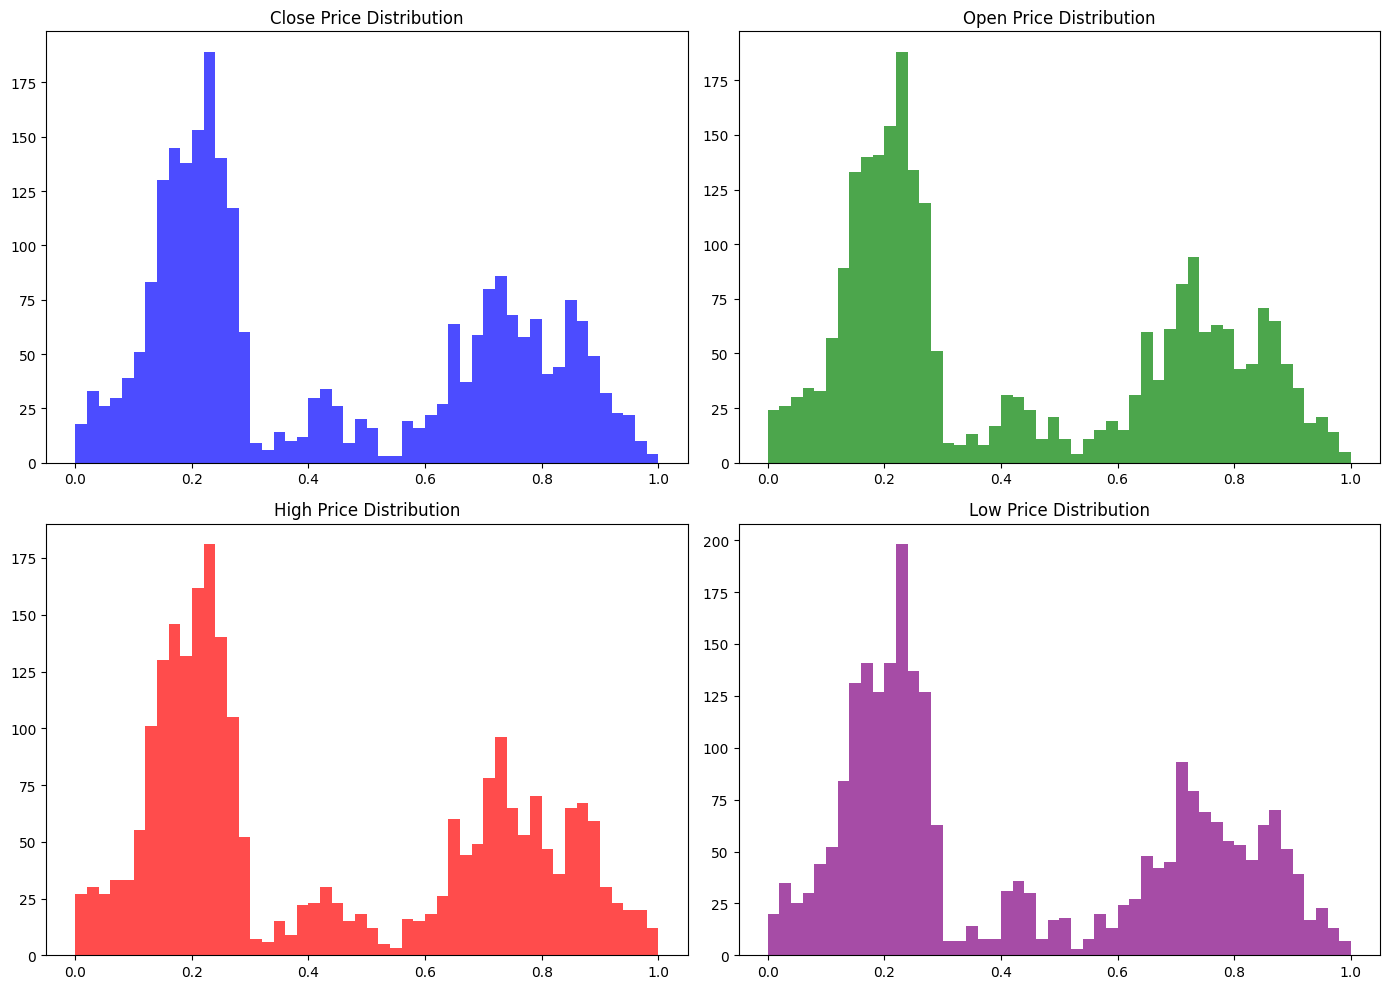

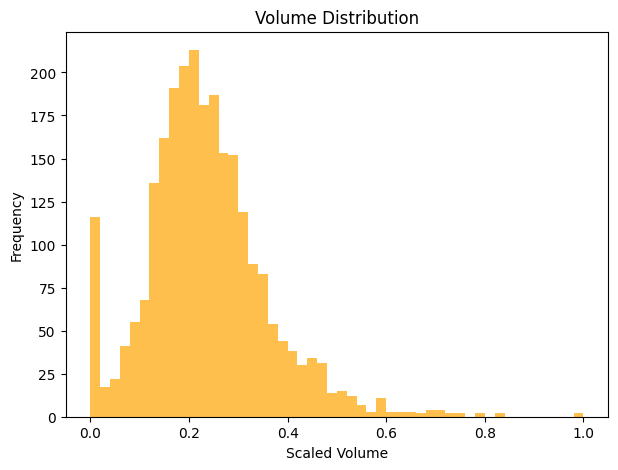

In [4]:
# EDA: Summary Statistics
summary_stats = df.describe()
print("Summary Statistics:")
print(summary_stats)

# EDA: Visualizing Distributions
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.hist(df['Close'], bins=50, color='blue', alpha=0.7)
plt.title('Close Price Distribution')

plt.subplot(2, 2, 2)
plt.hist(df['Open'], bins=50, color='green', alpha=0.7)
plt.title('Open Price Distribution')

plt.subplot(2, 2, 3)
plt.hist(df['High'], bins=50, color='red', alpha=0.7)
plt.title('High Price Distribution')

plt.subplot(2, 2, 4)
plt.hist(df['Low'], bins=50, color='purple', alpha=0.7)
plt.title('Low Price Distribution')

plt.tight_layout()
plt.show()

# Visualizing the trading volume distribution
plt.figure(figsize=(7, 5))
plt.hist(df['Volume'], bins=50, color='orange', alpha=0.7)
plt.title('Volume Distribution')
plt.xlabel('Scaled Volume')
plt.ylabel('Frequency')
plt.show()

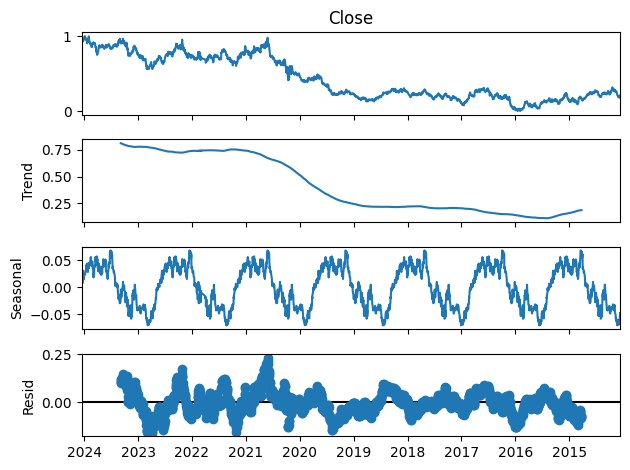

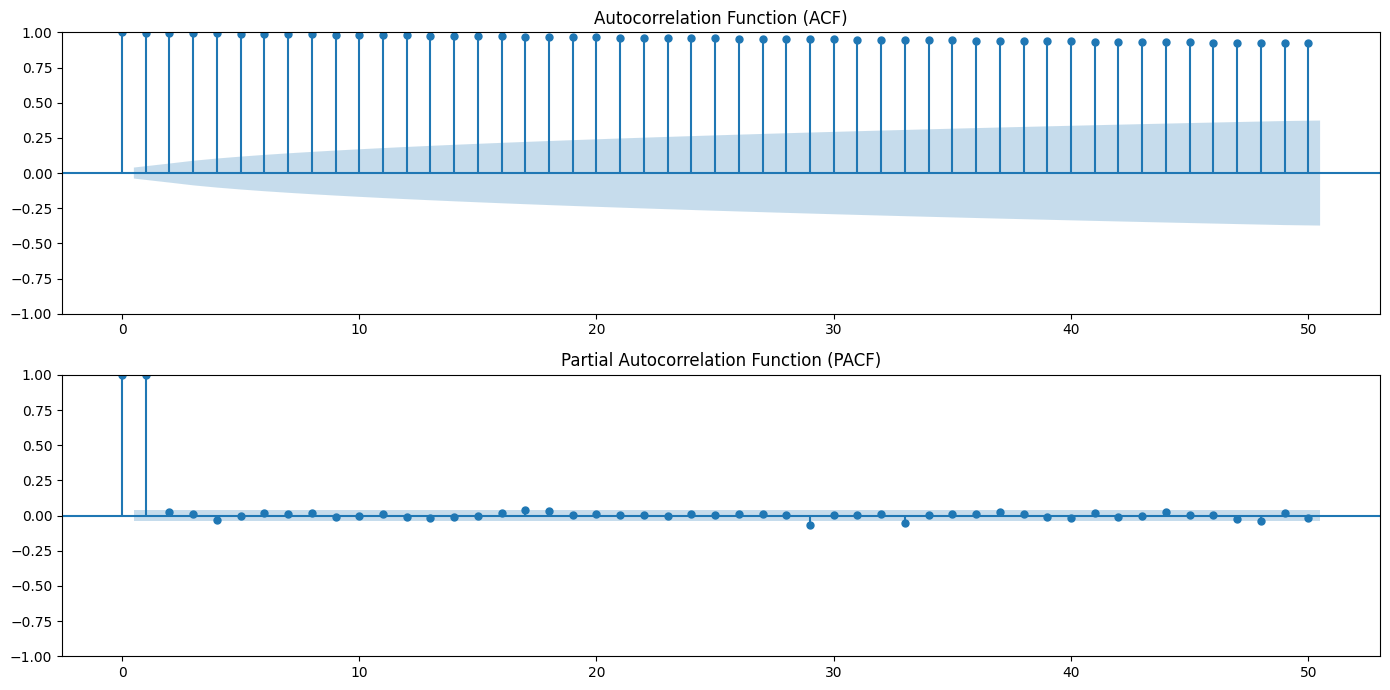

In [5]:
# Decompose the time series
result = seasonal_decompose(df['Close'], model='additive', period=365)
result.plot()
plt.show()

# Plot ACF and PACF
plt.figure(figsize=(14, 7))

# Autocorrelation Function
plt.subplot(2, 1, 1)
plot_acf(df['Close'].dropna(), lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function
plt.subplot(2, 1, 2)
plot_pacf(df['Close'].dropna(), lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Training set size: 2004
Testing set size: 502
Mean Squared Error: 0.00011159223710422103
R-squared: 0.9802235219419427


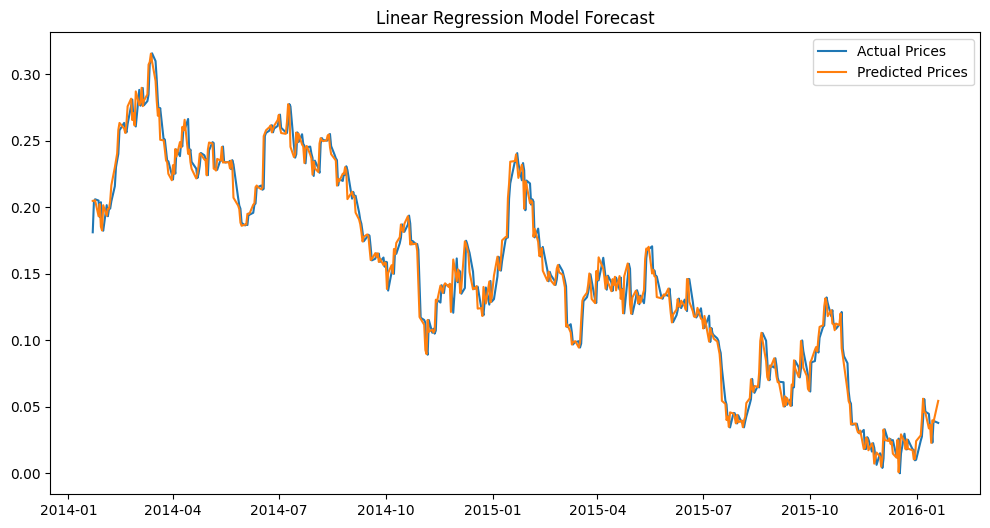

In [6]:
# Create lagged features
def create_lagged_features(data, lags=5):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lags + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.columns = [f'lag_{i}' for i in range(lags, 0, -1)] + ['target']
    df.dropna(inplace=True)
    return df

lags = 5
data_with_lags = create_lagged_features(df['Close'].values, lags)

# Split the data into features (X) and target (y)
X = data_with_lags.drop('target', axis=1).values
y = data_with_lags['target'].values

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + lags:], y_test, label='Actual Prices')
plt.plot(df.index[train_size + lags:], y_pred, label='Predicted Prices')
plt.legend(loc='best')
plt.title('Linear Regression Model Forecast')
plt.show()

Mean Squared Error: 0.00020247502846561845
R-squared: 0.964117190750329


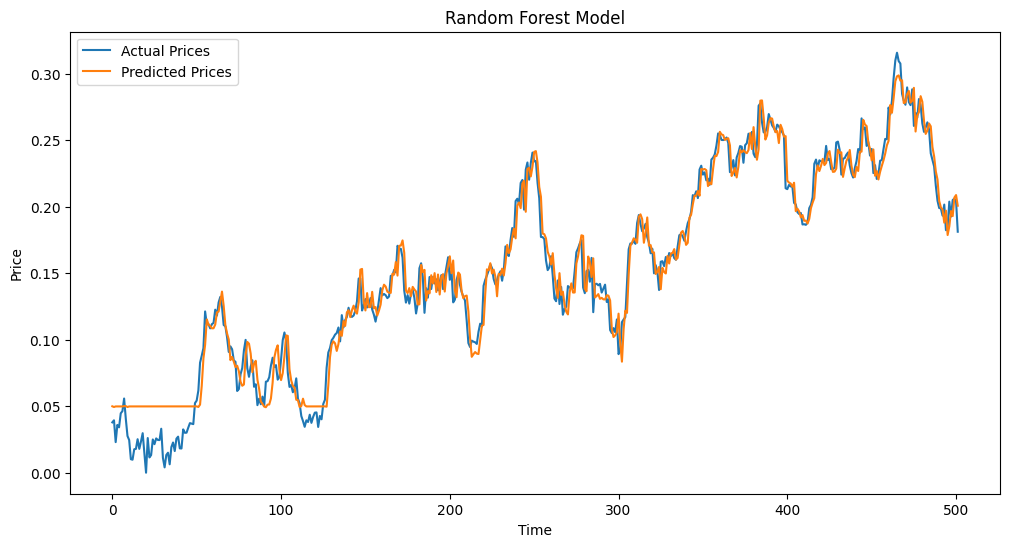

In [7]:
from sklearn.ensemble import RandomForestRegressor
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('Random Forest Model')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

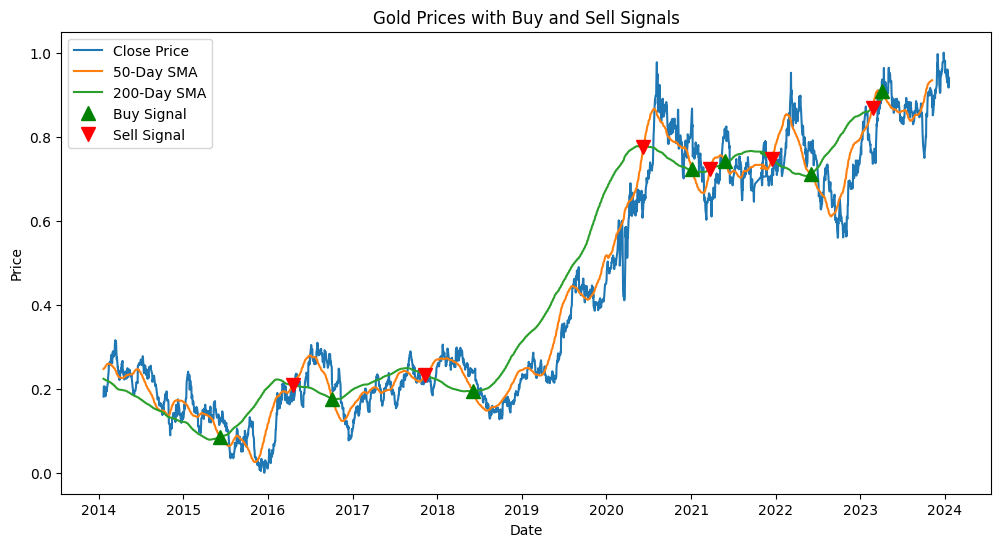

In [8]:
# Calculate short-term (50-day) and long-term (200-day) moving averages
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# Initialize the 'Signal' column
df['Signal'] = 0

# Generate trading signals using iloc for integer-based indexing
df.iloc[50:, df.columns.get_loc('Signal')] = np.where(df.iloc[50:, df.columns.get_loc('SMA_50')] > df.iloc[50:, df.columns.get_loc('SMA_200')], 1, 0)

# Calculate the 'Position' column
df['Position'] = df['Signal'].diff()

# Plot the signals on the price chart
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA_50'], label='50-Day SMA')
plt.plot(df['SMA_200'], label='200-Day SMA')

# Plot buy signals
plt.plot(df[df['Position'] == 1].index,
         df['SMA_50'][df['Position'] == 1],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot sell signals
plt.plot(df[df['Position'] == -1].index,
         df['SMA_50'][df['Position'] == -1],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('Gold Prices with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


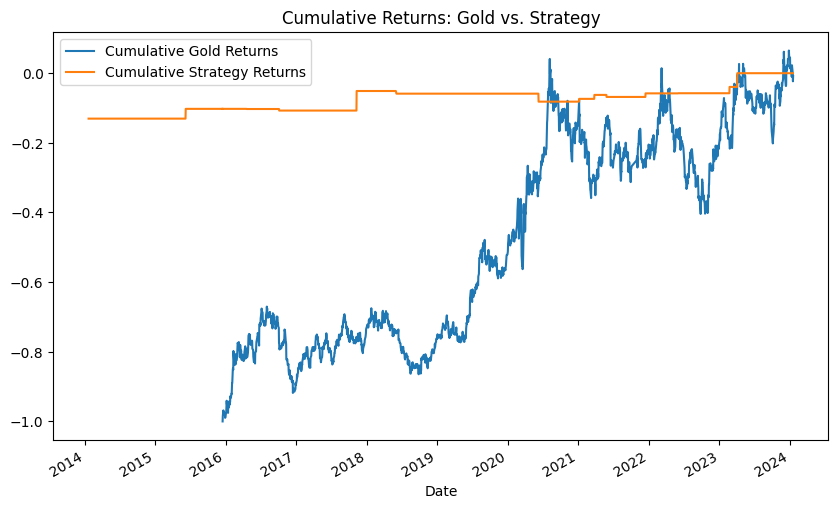

In [9]:
# Calculate returns
df['Gold Returns'] = df['Close'].pct_change()
df['Strategy Returns'] = df['Gold Returns'] * df['Position'].shift(1)

# Calculate cumulative returns
df['Cumulative Gold Returns'] = (1 + df['Gold Returns']).cumprod() - 1
df['Cumulative Strategy Returns'] = (1 + df['Strategy Returns']).cumprod() - 1

# Plot cumulative returns
df[['Cumulative Gold Returns', 'Cumulative Strategy Returns']].plot(figsize=(10, 6))
plt.title('Cumulative Returns: Gold vs. Strategy')
plt.show()


In [10]:
# Performance metrics
sharpe_ratio = df['Strategy Returns'].mean() / df['Strategy Returns'].std() * np.sqrt(252)
max_drawdown = (df['Cumulative Strategy Returns'].cummax() - df['Cumulative Strategy Returns']).max()

print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Max Drawdown: {max_drawdown}')


Sharpe Ratio: -0.4982243417959194
Max Drawdown: 0.13046182256402816


In [11]:
import nltk
from textblob import TextBlob
nltk.download('punkt')

# Example event data (In practice, collect this from news websites or APIs)
events = [
    "Gold prices are expected to rise due to economic uncertainty.",
    "Investors are losing confidence in gold as an asset.",
    "Central banks are increasing their gold reserves.",
    "The gold market is experiencing high volatility."
]

# Analyze sentiment
for event in events:
    analysis = TextBlob(event)
    print(f'Event: {event}')
    print(f'Sentiment: {analysis.sentiment}\n')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Event: Gold prices are expected to rise due to economic uncertainty.
Sentiment: Sentiment(polarity=-0.008333333333333331, subjectivity=0.325)

Event: Investors are losing confidence in gold as an asset.
Sentiment: Sentiment(polarity=0.0, subjectivity=0.0)

Event: Central banks are increasing their gold reserves.
Sentiment: Sentiment(polarity=0.0, subjectivity=0.25)

Event: The gold market is experiencing high volatility.
Sentiment: Sentiment(polarity=0.16, subjectivity=0.5399999999999999)

